ARIMA, short for ‘AutoRegressive Integrated Moving Average’, is a forecasting algorithm based on the idea that the information in the past values of the time series can __alone__ be used to predict the future values.

- ARIMA is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

- Any __‘non-seasonal’__ time series that exhibits patterns and is __not a random white noise__ can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: p, d, q. Where:
<br> - p is the order of the ‘Auto Regressive’ AR term
 > 'p' refers to the number of lags of Y to be used as predictors.

<br> - q is the order of the ‘Moving Average’ MA term
 > 'q' refers to the number of lagged forecast errors that should go into the ARIMA Model.
 
<br> - d is the number of differencing required to make the time series stationary
 > The value of d, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then d = 0.

If a time series, has seasonal patterns, then need to add seasonal terms and it becomes __SARIMA__, short for ‘Seasonal ARIMA’.

## import libraries

In [1]:
import pmdarima

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

## import data

In [3]:
df_AAPL = pd.read_csv('AAPL_hist_price.csv')

## modify columns for plotting

In [4]:
# set label as DateTimeIndex
df_AAPL['label'] = pd.DatetimeIndex(df_AAPL.label)
# set index for label
df_AAPL = df_AAPL.set_index('label')

## reverse index time - from furthest to nearest
df_AAPL = df_AAPL.iloc[::-1]
df_AAPL.head()

,change,changeOverTime,changePercent,close,fClose,fHigh,fLow,fOpen,fVolume,high,...,open,subkey,symbol,uClose,uHigh,uLow,uOpen,uVolume,updated,volume
label,,,,,,,,,,,,,,,,,,,,,
2016-04-04,0.3275,-0.774146,0.0119,27.7800,25.8384,26.0872,25.6408,25.6757,149424816,28.0475,...,27.6050,NaN,AAPL,111.12,112.19,110.270,110.42,37356204,2021-02-05 02:16:39,149424816
2016-04-05,-0.2875,-0.776809,-0.0104,27.4525,25.5338,25.7477,25.4431,25.4641,106314608,27.6825,...,27.3775,NaN,AAPL,109.81,110.73,109.420,109.51,26578652,2021-02-05 02:17:33,106314608
2016-04-06,0.6050,-0.774472,0.0223,27.7400,25.8012,25.8059,25.3920,25.6315,105616308,27.7450,...,27.5575,NaN,AAPL,110.96,110.98,109.200,110.23,26404077,2021-02-05 02:16:05,105616308
2016-04-07,-0.0300,-0.779390,-0.0011,27.1350,25.2385,25.6757,25.1411,25.5664,127207480,27.6050,...,27.4875,NaN,AAPL,108.54,110.42,108.121,109.95,31801870,2021-02-05 02:16:05,127207480
2016-04-08,-0.0900,-0.779146,-0.0033,27.1650,25.2664,25.5245,25.1525,25.3245,94326960,27.4425,...,27.2275,NaN,AAPL,108.66,109.77,108.170,108.91,23581740,2021-02-05 02:17:01,94326960


In [5]:
df_AAPL.shape

(1258, 24)

## test stationarity - using ADF test

ADF - Augmented Dickey Fuller test - from the statsmodels package
<br> - The __null hypothesis__ of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.
<br> - if P Value > 0.05 we go ahead with finding the order of differencing (d).

In [6]:
## function from Kaggle
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

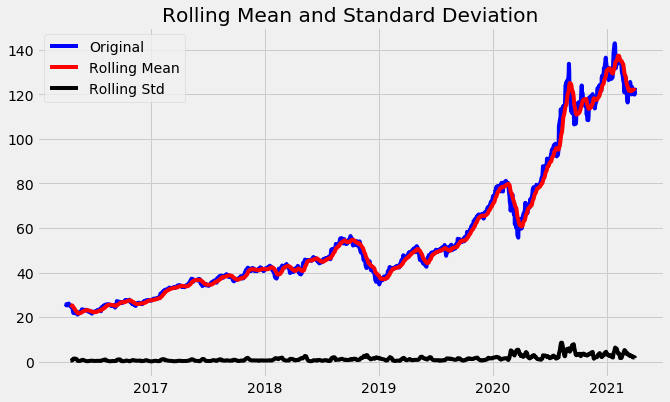

Results of dickey fuller test
Test Statistics                   0.270717
p-value                           0.975960
No. of lags used                 20.000000
Number of observations used    1237.000000
critical value (1%)              -3.435647
critical value (5%)              -2.863879
critical value (10%)             -2.568015
dtype: float64


In [7]:
test_stationarity(df_AAPL['fClose'])

If both mean and std are flat lines (constant variance), the series becomes stationary
<br> But, there are the increasing in mean and std in the graph above, therefore it's not stationary

In other way, p-value = 0.9759 > 0.05, we fail to reject the Null. So the data is non-stationary

## separate seasonality and trend from series

The resultant series will become stationary through this process??? No, I makes it stationarity
-  Identifying and removing the seasonal component from the time series can result in a clearer relationship between input and output variables.

<Figure size 720x432 with 0 Axes>

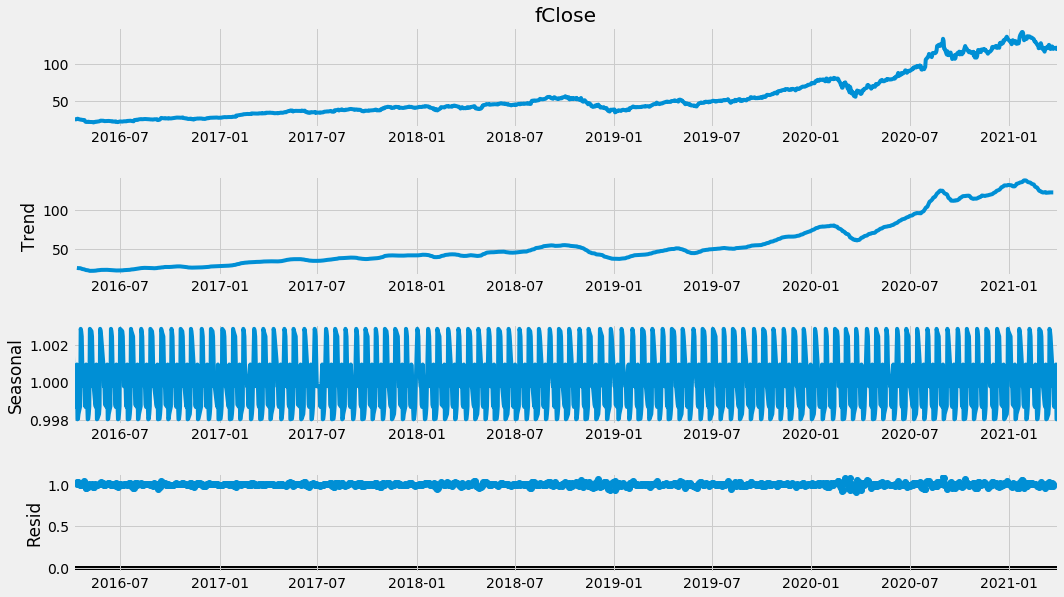

In [8]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result_AAPL = seasonal_decompose(df_AAPL['fClose'], model='multiplicative', freq = 13)
fig_AAPL = plt.figure()  
fig_AAPL = result_AAPL.plot()  
fig_AAPL.set_size_inches(16, 9)

## modify data

- Taking log of fClose to reduce the magnitude of the values and reduce the rising trend in the series.
- Finding the rolling average (calculated by taking input of the past 12 months and giving a mean consumption value at every point further ahead in series) of the series. 

No handles with labels found to put in legend.


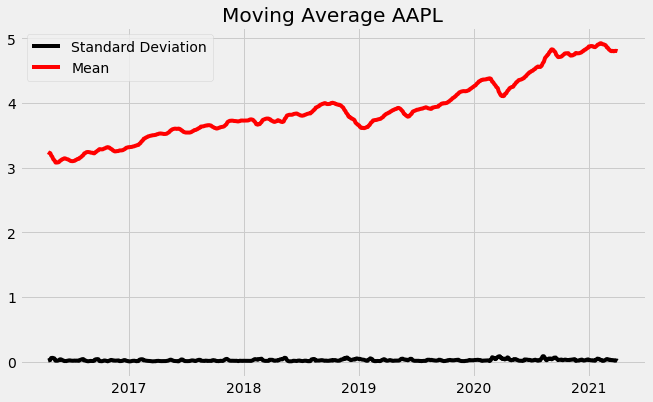

In [9]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log_AAPL = np.log(df_AAPL['fClose'])
moving_avg_AAPL = df_log_AAPL.rolling(12).mean()
std_dev_AAPL = df_log_AAPL.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average AAPL')
plt.plot(std_dev_AAPL, color ="black", label = "Standard Deviation")
plt.plot(moving_avg_AAPL, color="red", label = "Mean")
plt.legend()
plt.show()

In [10]:
df_log_AAPL.shape

(1258,)

## ARIMA model

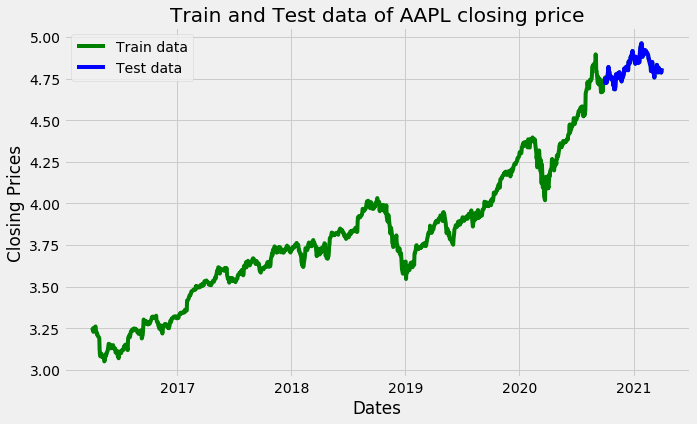

In [11]:
#split data into train and training set
train_data_AAPL, test_data_AAPL = df_log_AAPL[3:int(len(df_log_AAPL)*0.9)], df_log_AAPL[int(len(df_log_AAPL)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.title('Train and Test data of AAPL closing price')
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log_AAPL, 'green', label='Train data')
plt.plot(test_data_AAPL, 'blue', label='Test data')
plt.legend()

In [12]:
train_data_AAPL.shape

(1129,)

In [13]:
test_data_AAPL.shape

(126,)

#### choosing parameters p,q,d for ARIMA model - Using auto ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5748.316, Time=0.90 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5760.339, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5759.527, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5744.593, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5759.068, Time=0.56 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5759.054, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5756.987, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5755.237, Time=0.26 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 3.475 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2883.169
Date:                Thu, 13 May 2021   AIC                          -5760.339
Time:                       

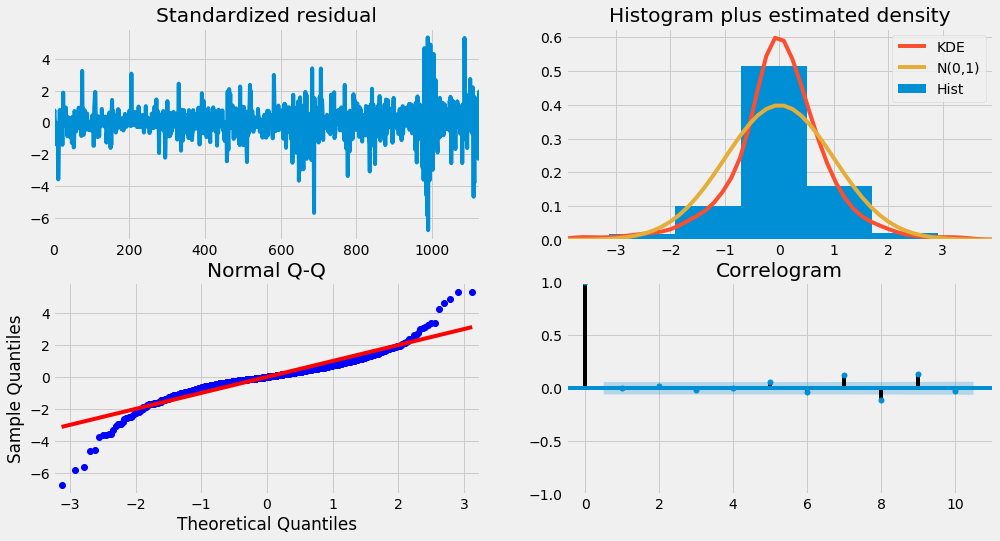

In [14]:
model_autoARIMA_AAPL = auto_arima(train_data_AAPL, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_AAPL.summary())
model_autoARIMA_AAPL.plot_diagnostics(figsize=(15,8))
plt.show()

- Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.
- Top right: The density plot suggest normal distribution with mean zero.
- Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.
- Bottom Right: The Correlogram (ACF)...

It seems to be a good fit -> start forecasting

###### Base on the result above, ARIMA(1,1,0)(0,0,0) is the best model. Therefore p = 1. q = 0 and d = 1

* p = 1: We are doing the AR using 1 value before it. 
* q = 0: zero lag we are taking from more moving average
* d = 1: we are doing 1 differencing so if there is any non-stationarity, it will transform into a stationarity

In [15]:
#Modeling
# Build Model
model_AAPL = ARIMA(train_data_AAPL, order=(1,1,0))  
fitted_AAPL = model_AAPL.fit(disp=-1)  
print(fitted_AAPL.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.fClose   No. Observations:                 1128
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2883.169
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 13 May 2021   AIC                          -5760.339
Time:                        18:33:55   BIC                          -5745.254
Sample:                             1   HQIC                         -5754.639
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0013      0.001      2.676      0.007       0.000       0.002
ar.L1.D.fClose    -0.1111      0.030     -3.756      0.000      -0.169      -0.053
                                    

##### forecast the stock prices on the test dataset keeping 95% confidence level.

In [16]:
# Forecast
fc_AAPL, se_AAPL, conf_AAPL = fitted_AAPL.forecast(126, alpha=0.05)  # 95% conf

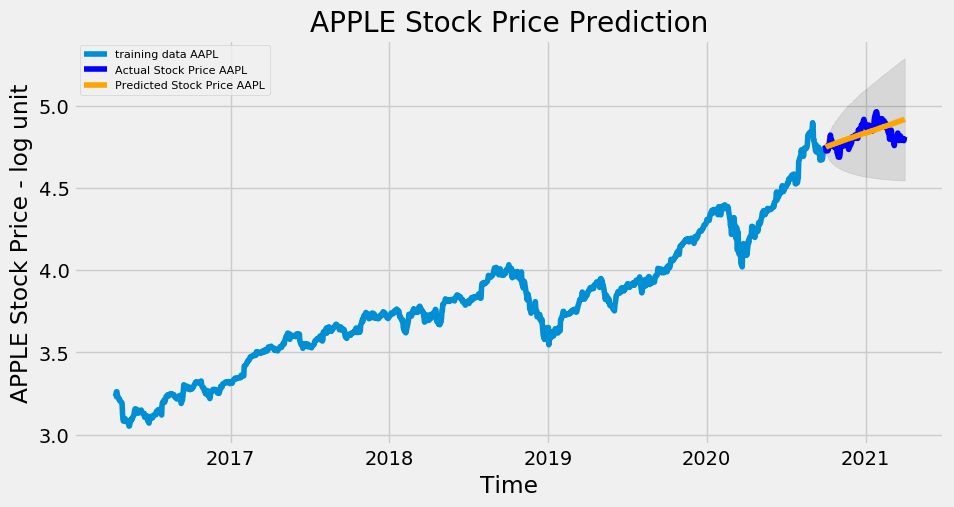

In [17]:
## plot the result

# Make as pandas series
fc_series_AAPL = pd.Series(fc_AAPL, index=test_data_AAPL.index)
lower_series_AAPL = pd.Series(conf_AAPL[:, 0], index=test_data_AAPL.index)
upper_series_AAPL = pd.Series(conf_AAPL[:, 1], index=test_data_AAPL.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_AAPL, label='training data AAPL')
plt.plot(test_data_AAPL, color = 'blue', label='Actual Stock Price AAPL')
plt.plot(fc_series_AAPL, color = 'orange',label='Predicted Stock Price AAPL')
plt.fill_between(lower_series_AAPL.index, lower_series_AAPL, upper_series_AAPL, 
                 color='k', alpha=.10)
plt.title('APPLE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price - log unit')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## report the performance

In [18]:
# report performance
mse_AAPL = mean_squared_error(test_data_AAPL, fc_AAPL)
print('MSE: '+str(mse_AAPL))
mae_AAPL = mean_absolute_error(test_data_AAPL, fc_AAPL)
print('MAE: '+str(mae_AAPL))
rmse_AAPL = math.sqrt(mean_squared_error(test_data_AAPL, fc_AAPL))
print('RMSE: '+str(rmse_AAPL))
mape_AAPL = np.mean(np.abs(fc_AAPL - test_data_AAPL)/np.abs(test_data_AAPL))
print('MAPE: '+str(mape_AAPL))

MSE: 0.003425669451693393
MAE: 0.04603283388888834
RMSE: 0.05852921878594821
MAPE: 0.00954892404778588


## forecast

In [19]:
start_index = len(train_data_AAPL)
end_index = start_index + 30
forecast = fitted_AAPL.predict(start=start_index, end=end_index)

In [20]:
fitted_AAPL.forecast()[0]

array([4.74856715])

## 5 months

In [21]:
df_log_AAPL.shape

(1258,)

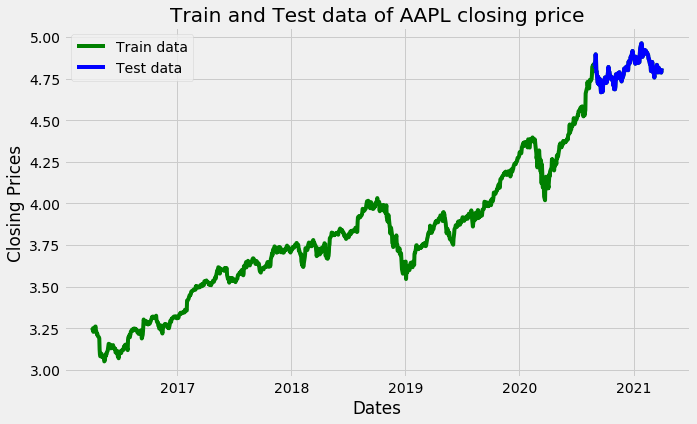

In [22]:
#split data into train and training set
train_data_AAPL_5months, test_data_AAPL_5months = df_log_AAPL[:1108], df_log_AAPL[1108:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.title('Train and Test data of AAPL closing price')
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log_AAPL, 'green', label='Train data')
plt.plot(test_data_AAPL_5months, 'blue', label='Test data')
plt.legend()

In [23]:
test_data_AAPL_5months.shape

(150,)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5693.320, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5706.289, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5705.286, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5688.676, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5705.265, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5705.169, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5703.273, Time=0.71 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5699.960, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.795 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1108
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2856.144
Date:                Thu, 13 May 2021   AIC                          -5706.289
Time:                       

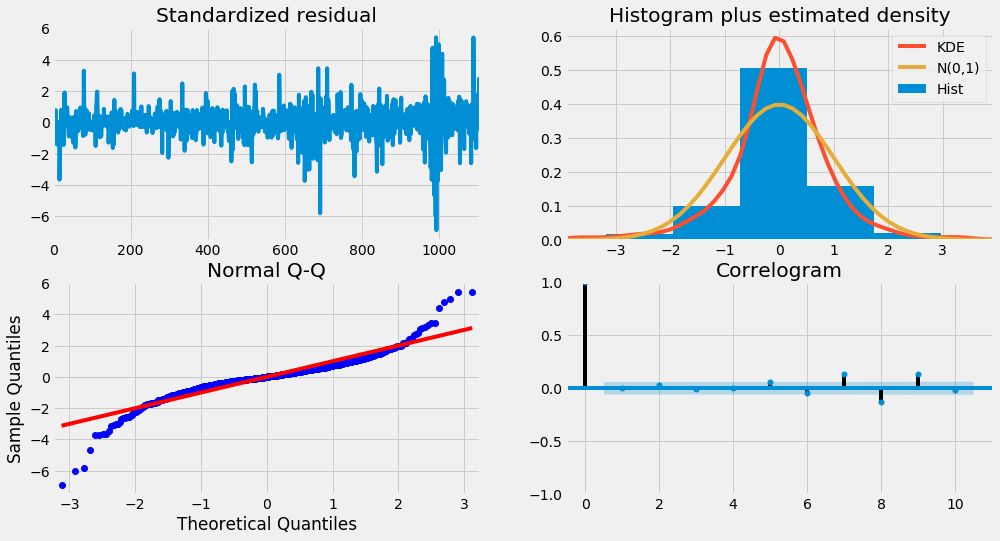

In [24]:
model_autoARIMA_AAPL_5months = auto_arima(train_data_AAPL_5months, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_AAPL_5months.summary())
model_autoARIMA_AAPL_5months.plot_diagnostics(figsize=(15,8))
plt.show()

In [25]:
#Modeling
# Build Model
model_AAPL_5months = ARIMA(train_data_AAPL_5months, order=(1,1,0))  
fitted_AAPL_5months = model_AAPL_5months.fit(disp=-1)  
print(fitted_AAPL_5months.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.fClose   No. Observations:                 1107
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2856.145
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 13 May 2021   AIC                          -5706.289
Time:                        18:33:59   BIC                          -5691.261
Sample:                             1   HQIC                         -5700.606
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0014      0.000      2.900      0.004       0.000       0.002
ar.L1.D.fClose    -0.1159      0.030     -3.882      0.000      -0.174      -0.057
                                    

In [26]:
# Forecast
fc_AAPL_5months, se_AAPL_5months, conf_AAPL_5months = fitted_AAPL_5months.forecast(150, alpha=0.05)  # 95% conf

Model 3: ARIMA
ARIMA is a time series model which stands for Auto-Regression (AR), Integrated (I) and Moving Average (MA). ARIMA is based on historical dataset and uses them to forecast the future. We choose ARIMA to analyze the data because it is a simple, fast and robust mechanism to forecast values. ARIMA can capture relationships as it takes error terms and observations of lagged terms. We apply ARIMA for the feature closing price of historical price dataset.
The assumption of ARIMA is the data needs to be stationary. Stationary is that the series does not depend on the time when it is captured. To check the stationary status of the dataset for each ticker, we use ADF test (augmented dickey fuller) and find the differencing (using auto_arima) to make them become stationary if they are not. We also remove the seasonality component to get the clearer relationship between input and output. Then we take log of closing price to reduce the magnitude of the values and reduce the rising trend in the series.
We split the dataset of each ticker to a different time range for training and validation (e.g. a week, a month, 3 months, 5 months) and use mean absolute percentage error (MAPE) to evaluate the model. 
Model3: ARIMA
ARIMA model has the MAPE scores under 5%. It means the models are about over 95% accurate in predicting in the chosen timeframe observations, with the 95% confidence. It seems not a bad result for the ARIMA model.


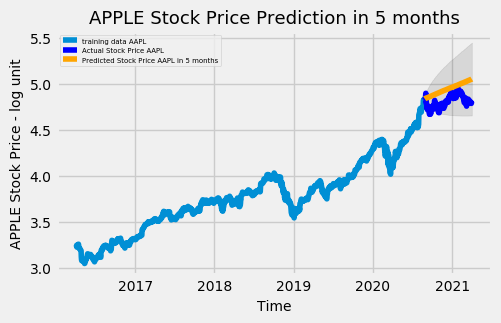

In [58]:
## plot the result

# Make as pandas series
fc_series_AAPL_5months = pd.Series(fc_AAPL_5months, index=test_data_AAPL_5months.index)
lower_series_AAPL_5months = pd.Series(conf_AAPL_5months[:, 0], index=test_data_AAPL_5months.index)
upper_series_AAPL_5months = pd.Series(conf_AAPL_5months[:, 1], index=test_data_AAPL_5months.index)
# Plot
plt.figure(figsize=(5,3), dpi=100)
plt.plot(train_data_AAPL_5months, label='training data AAPL')
plt.plot(test_data_AAPL_5months, color = 'blue', label='Actual Stock Price AAPL')
plt.plot(fc_series_AAPL_5months, color = 'orange',label='Predicted Stock Price AAPL in 5 months')
plt.fill_between(lower_series_AAPL_5months.index, lower_series_AAPL_5months, upper_series_AAPL_5months, 
                 color='k', alpha=.10)
plt.title('APPLE Stock Price Prediction in 5 months', fontsize = 13)
plt.xlabel('Time', fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.ylabel('APPLE Stock Price - log unit', fontsize = 10)
plt.legend(loc='upper left', fontsize=5)
plt.show()

In [28]:
# report performance
mse_AAPL_5months = mean_squared_error(test_data_AAPL_5months, fc_AAPL_5months)
print('MSE: '+str(mse_AAPL_5months))
mae_AAPL_5months = mean_absolute_error(test_data_AAPL_5months, fc_AAPL_5months)
print('MAE: '+str(mae_AAPL_5months))
rmse_AAPL_5months = math.sqrt(mean_squared_error(test_data_AAPL_5months, fc_AAPL_5months))
print('RMSE: '+str(rmse_AAPL_5months))
mape_AAPL_5months = np.mean(np.abs(fc_AAPL_5months - test_data_AAPL_5months)/np.abs(test_data_AAPL_5months))
print('MAPE: '+str(mape_AAPL_5months))

MSE: 0.022285280158952668
MAE: 0.13724291336873284
RMSE: 0.14928255142163355
MAPE: 0.028637471496639665


## 3 months

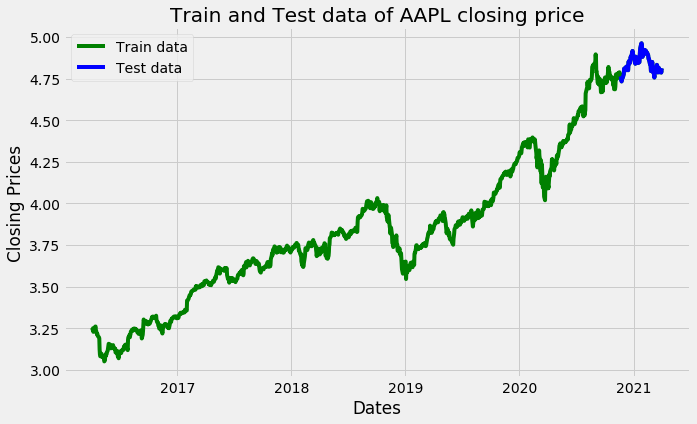

In [29]:
#split data into train and training set
train_data_AAPL_3months, test_data_AAPL_3months = df_log_AAPL[:1168], df_log_AAPL[1168:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.title('Train and Test data of AAPL closing price')
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log_AAPL, 'green', label='Train data')
plt.plot(test_data_AAPL_3months, 'blue', label='Test data')
plt.legend()

In [30]:
test_data_AAPL_3months.shape

(90,)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5925.475, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5940.254, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5939.214, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5922.026, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5939.147, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5939.142, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5936.729, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5935.357, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.450 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1168
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2973.127
Date:                Thu, 13 May 2021   AIC                          -5940.254
Time:                       

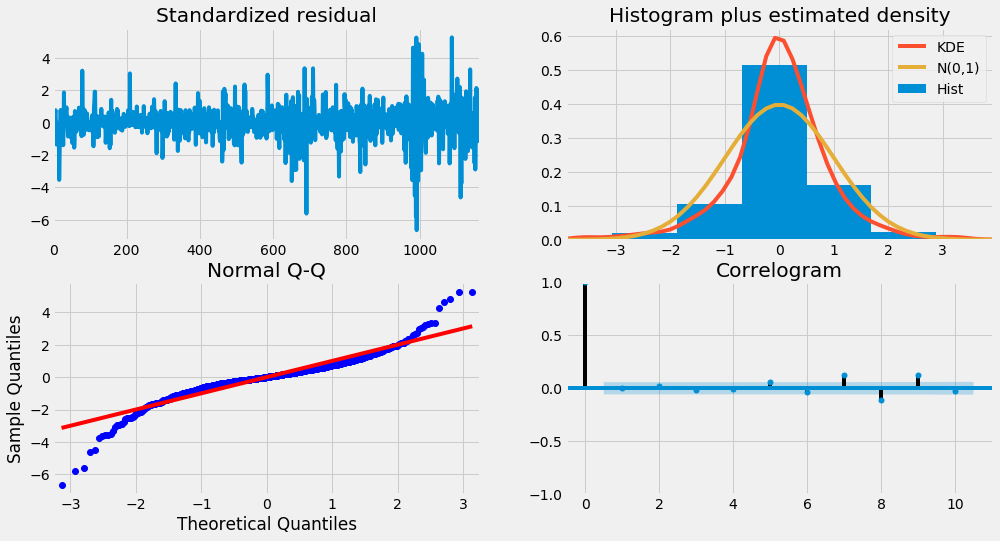

In [31]:
model_autoARIMA_AAPL_3months = auto_arima(train_data_AAPL_3months, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_AAPL_3months.summary())
model_autoARIMA_AAPL_3months.plot_diagnostics(figsize=(15,8))
plt.show()

In [32]:
#Modeling
# Build Model
model_AAPL_3months = ARIMA(train_data_AAPL_3months, order=(1,1,0))  
fitted_AAPL_3months = model_AAPL_3months.fit(disp=-1)  
print(fitted_AAPL_3months.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.fClose   No. Observations:                 1167
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2973.127
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 13 May 2021   AIC                          -5940.255
Time:                        18:34:02   BIC                          -5925.068
Sample:                             1   HQIC                         -5934.526
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0013      0.000      2.636      0.008       0.000       0.002
ar.L1.D.fClose    -0.1195      0.029     -4.111      0.000      -0.176      -0.063
                                    

In [33]:
# Forecast
fc_AAPL_3months, se_AAPL_3months, conf_AAPL_3months = fitted_AAPL_3months.forecast(90, alpha=0.05)  # 95% conf

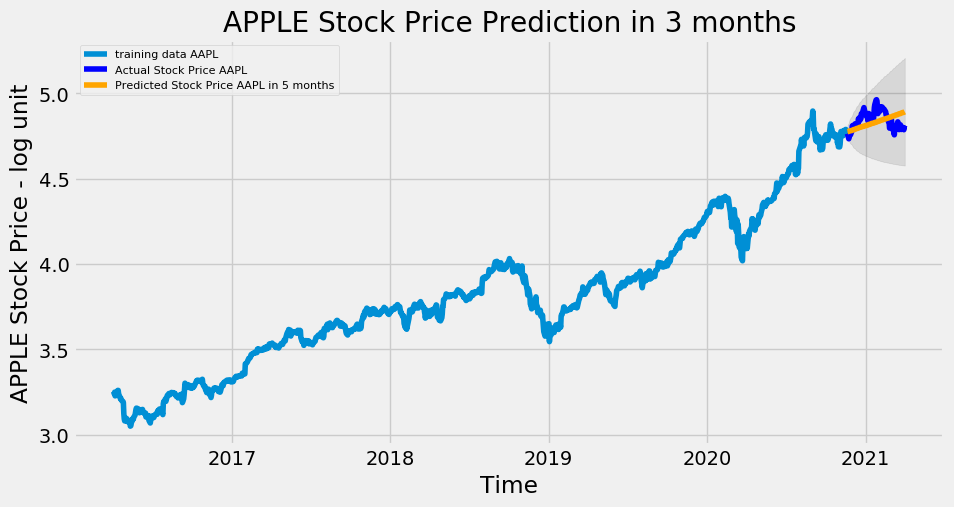

In [34]:
## plot the result

# Make as pandas series
fc_series_AAPL_3months = pd.Series(fc_AAPL_3months, index=test_data_AAPL_3months.index)
lower_series_AAPL_3months = pd.Series(conf_AAPL_3months[:, 0], index=test_data_AAPL_3months.index)
upper_series_AAPL_3months = pd.Series(conf_AAPL_3months[:, 1], index=test_data_AAPL_3months.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_AAPL_3months, label='training data AAPL')
plt.plot(test_data_AAPL_3months, color = 'blue', label='Actual Stock Price AAPL')
plt.plot(fc_series_AAPL_3months, color = 'orange',label='Predicted Stock Price AAPL in 5 months')
plt.fill_between(lower_series_AAPL_3months.index, lower_series_AAPL_3months, upper_series_AAPL_3months, 
                 color='k', alpha=.10)
plt.title('APPLE Stock Price Prediction in 3 months')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price - log unit')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [35]:
# report performance
mse_AAPL_3months = mean_squared_error(test_data_AAPL_3months, fc_AAPL_3months)
print('MSE: '+str(mse_AAPL_3months))
mae_AAPL_3months = mean_absolute_error(test_data_AAPL_3months, fc_AAPL_3months)
print('MAE: '+str(mae_AAPL_3months))
rmse_AAPL_3months = math.sqrt(mean_squared_error(test_data_AAPL_3months, fc_AAPL_3months))
print('RMSE: '+str(rmse_AAPL_3months))
mape_AAPL_3months = np.mean(np.abs(fc_AAPL_3months - test_data_AAPL_3months)/np.abs(test_data_AAPL_3months))
print('MAPE: '+str(mape_AAPL_3months))

MSE: 0.004144528464567318
MAE: 0.056889493444996664
RMSE: 0.06437801227567777
MAPE: 0.011722914021676252


## 1 month

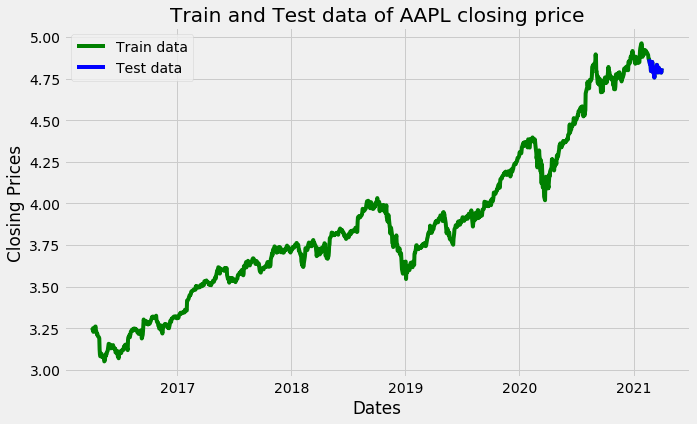

In [36]:
#split data into train and training set
train_data_AAPL_1month, test_data_AAPL_1month = df_log_AAPL[:1228], df_log_AAPL[1228:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.title('Train and Test data of AAPL closing price')
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log_AAPL, 'green', label='Train data')
plt.plot(test_data_AAPL_1month, 'blue', label='Test data')
plt.legend()

In [37]:
test_data_AAPL_1month.shape

(30,)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6232.803, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6245.755, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6244.885, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6228.974, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6244.589, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6244.509, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6242.453, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6240.504, Time=0.26 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.693 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1228
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3125.877
Date:                Thu, 13 May 2021   AIC                          -6245.755
Time:                       

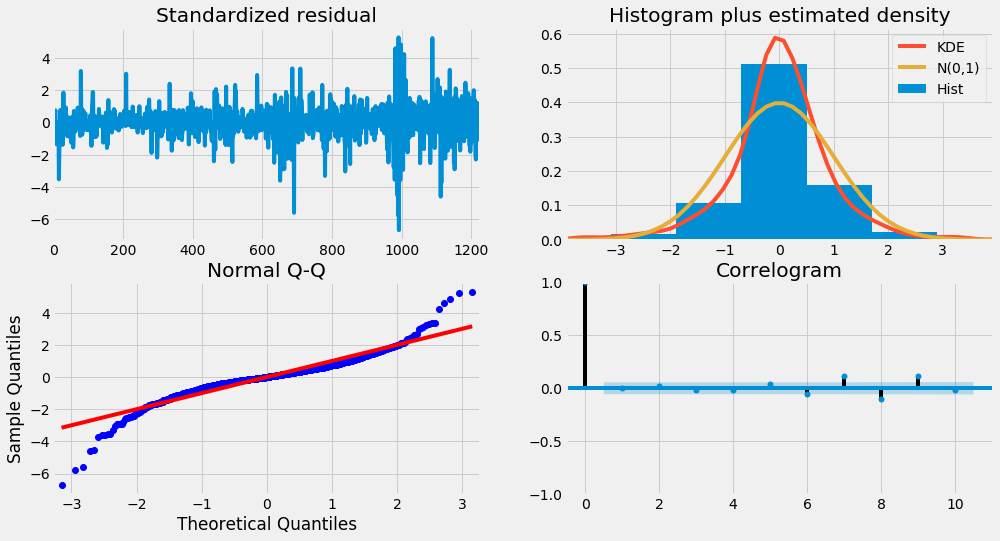

In [38]:
model_autoARIMA_AAPL_1month = auto_arima(train_data_AAPL_1month, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_AAPL_1month.summary())
model_autoARIMA_AAPL_1month.plot_diagnostics(figsize=(15,8))
plt.show()

In [39]:
#Modeling
# Build Model
model_AAPL_1month = ARIMA(train_data_AAPL_1month, order=(1,1,0))  
fitted_AAPL_1month = model_AAPL_1month.fit(disp=-1)  
print(fitted_AAPL_1month.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.fClose   No. Observations:                 1227
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3125.878
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 13 May 2021   AIC                          -6245.755
Time:                        18:34:06   BIC                          -6230.418
Sample:                             1   HQIC                         -6239.984
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0013      0.000      2.703      0.007       0.000       0.002
ar.L1.D.fClose    -0.1100      0.028     -3.879      0.000      -0.166      -0.054
                                    

In [40]:
# Forecast
fc_AAPL_1month, se_AAPL_1month, conf_AAPL_1month = fitted_AAPL_1month.forecast(30, alpha=0.05)  # 95% conf

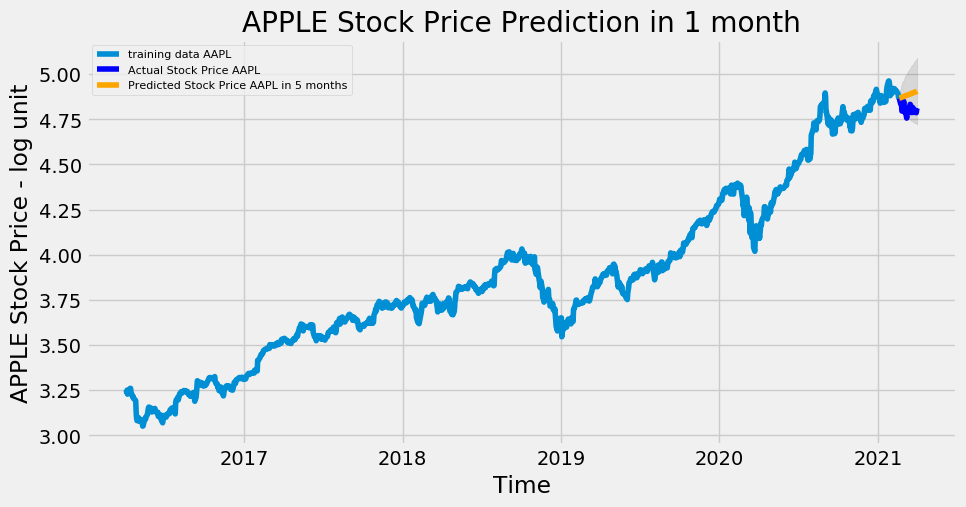

In [41]:
## plot the result

# Make as pandas series
fc_series_AAPL_1month = pd.Series(fc_AAPL_1month, index=test_data_AAPL_1month.index)
lower_series_AAPL_1month = pd.Series(conf_AAPL_1month[:, 0], index=test_data_AAPL_1month.index)
upper_series_AAPL_1month = pd.Series(conf_AAPL_1month[:, 1], index=test_data_AAPL_1month.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_AAPL_1month, label='training data AAPL')
plt.plot(test_data_AAPL_1month, color = 'blue', label='Actual Stock Price AAPL')
plt.plot(fc_series_AAPL_1month, color = 'orange',label='Predicted Stock Price AAPL in 5 months')
plt.fill_between(lower_series_AAPL_1month.index, lower_series_AAPL_1month, upper_series_AAPL_1month, 
                 color='k', alpha=.10)
plt.title('APPLE Stock Price Prediction in 1 month')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price - log unit')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [42]:
# report performance
mse_AAPL_1month = mean_squared_error(test_data_AAPL_1month, fc_AAPL_1month)
print('MSE: '+str(mse_AAPL_1month))
mae_AAPL_1month = mean_absolute_error(test_data_AAPL_1month, fc_AAPL_1month)
print('MAE: '+str(mae_AAPL_1month))
rmse_AAPL_1month = math.sqrt(mean_squared_error(test_data_AAPL_1month, fc_AAPL_1month))
print('RMSE: '+str(rmse_AAPL_1month))
mape_AAPL_1month = np.mean(np.abs(fc_AAPL_1month - test_data_AAPL_1month)/np.abs(test_data_AAPL_1month))
print('MAPE: '+str(mape_AAPL_1month))

MSE: 0.007047711320254681
MAE: 0.07874557526921742
RMSE: 0.08395064812289826
MAPE: 0.016404737214463953


## a week

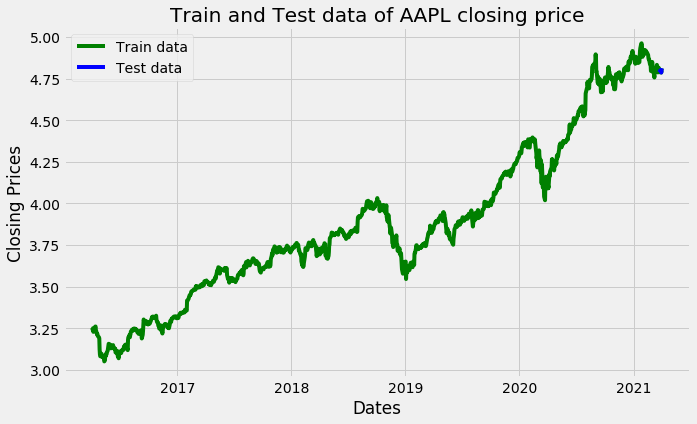

In [43]:
#split data into train and training set
train_data_AAPL_1week, test_data_AAPL_1week = df_log_AAPL[:1251], df_log_AAPL[1251:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.title('Train and Test data of AAPL closing price')
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log_AAPL, 'green', label='Train data')
plt.plot(test_data_AAPL_1week, 'blue', label='Test data')
plt.legend()

In [44]:
test_data_AAPL_1week.shape

(7,)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6336.468, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6350.461, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6349.663, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6333.197, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6349.024, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6349.047, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6346.790, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6345.866, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.401 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1251
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3178.231
Date:                Thu, 13 May 2021   AIC                          -6350.461
Time:                       

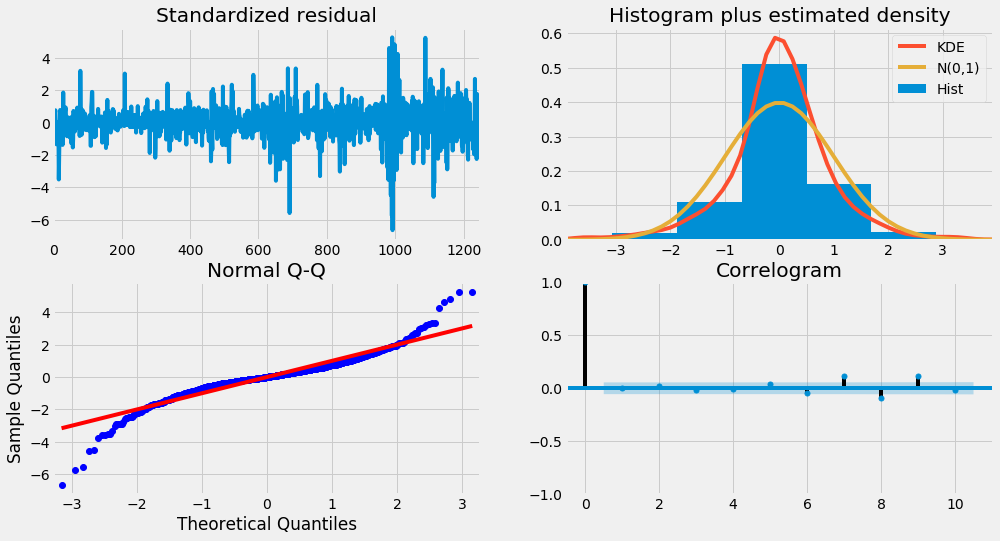

In [45]:
model_autoARIMA_AAPL_1week = auto_arima(train_data_AAPL_1week, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_AAPL_1week.summary())
model_autoARIMA_AAPL_1week.plot_diagnostics(figsize=(15,8))
plt.show()

In [46]:
#Modeling
# Build Model
model_AAPL_1week = ARIMA(train_data_AAPL_1week, order=(1,1,0))  
fitted_AAPL_1week = model_AAPL_1week.fit(disp=-1)  
print(fitted_AAPL_1week.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.fClose   No. Observations:                 1250
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3178.231
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 13 May 2021   AIC                          -6350.461
Time:                        18:34:09   BIC                          -6335.069
Sample:                             1   HQIC                         -6344.675
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0012      0.000      2.577      0.010       0.000       0.002
ar.L1.D.fClose    -0.1127      0.028     -4.012      0.000      -0.168      -0.058
                                    

In [47]:
# Forecast
fc_AAPL_1week, se_AAPL_1week, conf_AAPL_1week = fitted_AAPL_1week.forecast(7, alpha=0.05)  # 95% conf

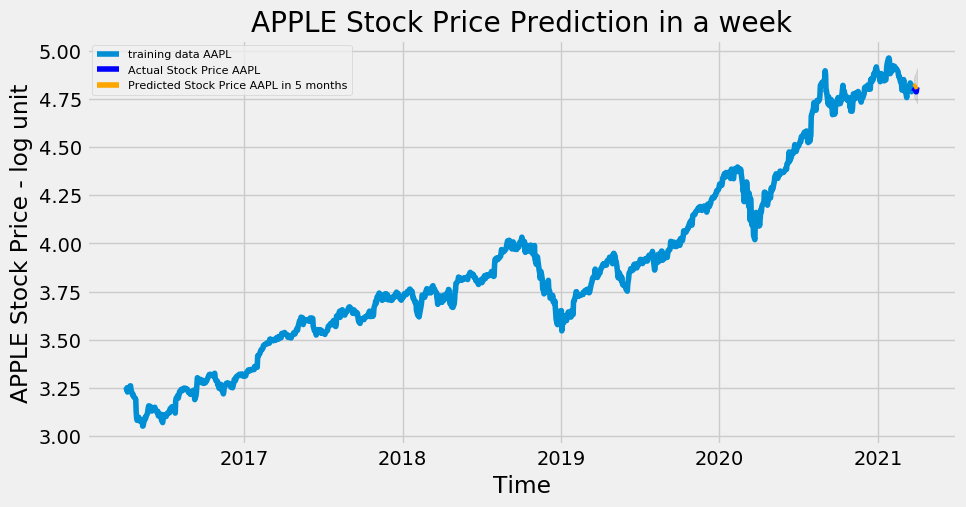

In [48]:
## plot the result

# Make as pandas series
fc_series_AAPL_1week = pd.Series(fc_AAPL_1week, index=test_data_AAPL_1week.index)
lower_series_AAPL_1week = pd.Series(conf_AAPL_1week[:, 0], index=test_data_AAPL_1week.index)
upper_series_AAPL_1week = pd.Series(conf_AAPL_1week[:, 1], index=test_data_AAPL_1week.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_AAPL_1week, label='training data AAPL')
plt.plot(test_data_AAPL_1week, color = 'blue', label='Actual Stock Price AAPL')
plt.plot(fc_series_AAPL_1week, color = 'orange',label='Predicted Stock Price AAPL in 5 months')
plt.fill_between(lower_series_AAPL_1week.index, lower_series_AAPL_1week, upper_series_AAPL_1week, 
                 color='k', alpha=.10)
plt.title('APPLE Stock Price Prediction in a week')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price - log unit')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [49]:
# report performance
mse_AAPL_1week = mean_squared_error(test_data_AAPL_1week, fc_AAPL_1week)
print('MSE: '+str(mse_AAPL_1week))
mae_AAPL_1week = mean_absolute_error(test_data_AAPL_1week, fc_AAPL_1week)
print('MAE: '+str(mae_AAPL_1week))
rmse_AAPL_1week = math.sqrt(mean_squared_error(test_data_AAPL_1week, fc_AAPL_1week))
print('RMSE: '+str(rmse_AAPL_1week))
mape_AAPL_1week = np.mean(np.abs(fc_AAPL_1week - test_data_AAPL_1week)/np.abs(test_data_AAPL_1week))
print('MAPE: '+str(mape_AAPL_1week))

MSE: 0.0003349043766720352
MAE: 0.016940773729169325
RMSE: 0.01830039280103122
MAPE: 0.0035337885488565452
